Project5

In [1]:
# import select functions and types
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import floor, round, monotonically_increasing_id, col
from pyspark.sql import SparkSession
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark import SparkFiles
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType
from concurrent.futures import ThreadPoolExecutor, as_completed

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import Normalizer, BucketedRandomProjectionLSH

from sparknlp.base import DocumentAssembler, Finisher
from sparknlp.annotator import UniversalSentenceEncoder
from pyspark.ml import Pipeline
from pyspark.sql.functions import concat_ws, col
from pyspark.ml.feature import Normalizer, BucketedRandomProjectionLSH

# import modules using an alias
import pyspark.sql.types as T
import pyspark.sql.functions as F
import requests
import matplotlib.pyplot as plt
import time
import csv
import os
import pandas as pd



GITHUB_URL = "https://raw.githubusercontent.com/farhodibr/datasets/heads/main/books_recommender/"

In [2]:
from pyspark import SparkConf
conf = SparkConf()
conf.setMaster("local[*]").setAppName("MySparkApp")
conf.set("spark.executor.memory", "10g")



spark = SparkSession.builder.config(conf=conf).getOrCreate()
spark.sparkContext.setCheckpointDir("checkpoint_dir_als")


In [3]:
#spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion()
#import subprocess
#subprocess.run(["winutils","ls"], check=True)



In [4]:

books_file_name = "Books"
ratings_file_name = "Ratings"
users_file_name = "Users"
filenames = [books_file_name, ratings_file_name, users_file_name]

for filename in filenames:
    download_url = f"{GITHUB_URL}/{filename}.csv"
    spark.sparkContext.addFile(download_url)

ratings_df = spark.read.csv(SparkFiles.get(f"{ratings_file_name}.csv"),
  header=True,
  inferSchema=True,
  sep=",")

books_df = spark.read.csv(SparkFiles.get(f"{books_file_name}.csv"),
  header=True,
  inferSchema=True,
  sep=",")

users_df = spark.read.csv(SparkFiles.get(f"{users_file_name}.csv"),
  header=True,
  inferSchema=True,
  sep=",")

ratings_df.show(5)

+-------+----------+-----------+
|User-ID|      ISBN|Book-Rating|
+-------+----------+-----------+
| 276725|034545104X|          0|
| 276726|0155061224|          5|
| 276727|0446520802|          0|
| 276729|052165615X|          3|
| 276729|0521795028|          6|
+-------+----------+-----------+
only showing top 5 rows



In [5]:
# ALS data preparation - ALS good for sparse data

users = users_df.select("User-ID").distinct()
# We dont wan't the same data/id to be used in different partitions, so just force use 1 partition for this
users = users.coalesce(1)
users = users.withColumn("userIntId", monotonically_increasing_id()).persist()

books = ratings_df.select("ISBN").distinct()
# We dont wan't the same data/id to be used in different partitions, so just force use 1 partition for this
books = books.coalesce(1)
# users_df = users_df.withColumn("userIntId", monotonically_increasing_id()).persist() # use persist to keep these values the same
books = books.withColumn("bookIntId", monotonically_increasing_id()).persist()

ratings_df_int_ids = ratings_df.join(users, "User-ID", "left").join(books, "ISBN", "left")
ratings_df_int_ids.show()

+----------+-------+-----------+---------+---------+
|      ISBN|User-ID|Book-Rating|userIntId|bookIntId|
+----------+-------+-----------+---------+---------+
|2080674722| 276733|          0|   275982|        0|
|0060517794| 276747|          9|   133919|    18744|
|0786013990| 276746|          0|     9804|    28964|
| 342310538| 276745|         10|    78013|    40921|
|034545104X| 276725|          0|   242789|    64860|
|055356451X| 276746|          0|     9804|    90526|
|0521795028| 276729|          6|    24942|   102491|
|0449006522| 276746|          0|     9804|   107555|
|0786014512| 276746|          0|     9804|   131215|
|0451192001| 276747|          0|   133919|   142826|
|0671537458| 276747|          9|   133919|   151387|
|052165615X| 276729|          3|    24942|   156580|
|0155061224| 276726|          5|   219046|   168644|
|0553561618| 276746|          0|     9804|   173656|
|0600570967| 276737|          6|   277429|   204294|
|0446520802| 276727|          0|    65452|   2

In [6]:
ratings = ratings_df_int_ids.select(col("userIntId").alias("userId"), col("bookIntId").alias("bookId"), col("Book-Rating").alias("rating"))
ratings.show()

+------+------+------+
|userId|bookId|rating|
+------+------+------+
|242789| 64860|     0|
|219046|168644|     5|
| 65452|240190|     0|
| 24942|156580|     3|
| 24942|102491|     6|
|275982|     0|     0|
|274623|301430|     8|
|277429|204294|     6|
|237146|301431|     7|
| 78013| 40921|    10|
|  9804|306388|     0|
|  9804|107555|     0|
|  9804|173656|     0|
|  9804| 90526|     0|
|  9804| 28964|     0|
|  9804|131215|     0|
|133919| 18744|     9|
|133919|142826|     0|
|133919|311556|     0|
|133919|151387|     9|
+------+------+------+
only showing top 20 rows



In [7]:
# Split the ratings dataframe into training and test data
(training_data, test_data) = ratings.randomSplit([0.7, 0.3], seed=42)

# Set the ALS hyperparameters

als = ALS(userCol="userId", itemCol="bookId", ratingCol="rating", rank = 10, maxIter = 15, regParam = .1,
          coldStartStrategy="drop", nonnegative = True, implicitPrefs = False)

# Fit the model to the training_data
model = als.fit(training_data)

# Generate predictions on the test_data
test_predictions = model.transform(test_data)

In [8]:
test_predictions.show()

+------+------+------+-----------+
|userId|bookId|rating| prediction|
+------+------+------+-----------+
|145228|    34|     0| 0.10684448|
| 14365|    34|     0|  5.0663733|
|128714|    34|     0| 0.11289924|
|130376|    34|     0| 0.41960835|
|274200|    34|     8|  2.9773424|
| 90440|    53|     7|  2.0651603|
|116087|    53|     0|  1.0652473|
|223520|    53|     9| 0.42036903|
|273592|    53|     0|  4.7714467|
| 74901|    53|     0|  2.2017493|
| 82958|    53|     0| 0.95018804|
| 28030|    65|     7|  2.9005756|
| 37995|    65|     0|   5.167667|
| 63123|    65|     0|    1.13513|
| 28794|    65|     7|  2.7777786|
|260877|    78|     0|        0.0|
|114723|    78|     0|        0.0|
|273592|    78|     5|  1.9608594|
|112408|    78|     0|0.075393066|
| 68061|    85|     0|  6.8757043|
+------+------+------+-----------+
only showing top 20 rows



In [9]:
""" # Hyperparameter tuning

# Takes too long at the moment
# param_grid = ParamGridBuilder() \
#            .addGrid(als.rank, [10, 50, 75, 100]) \
#            .addGrid(als.maxIter, [5, 50, 100, 200]) \
#            .addGrid(als.regParam, [.01, .05, .1, .15]) \
#            .build()

param_grid = ParamGridBuilder() \
           .addGrid(als.rank, [10, 50]) \
           .addGrid(als.maxIter, [5, 50]) \
           .addGrid(als.regParam, [.01, .05]) \
           .build()

# Define evaluator as RMSE and print length of evaluator
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Use cross validation
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

# Checkpoint the training data to truncate its lineage.
# This is a lazy operation, it will be triggered by the .fit() call.
training_data_chkp = training_data.checkpoint()

# Fit the cross validator on the CHECKPOINTED DataFrame.
model = cv.fit(training_data_chkp)

# --- MODIFICATION END ---

best_model = model.bestModel


print (f"{len(param_grid)} models tested") """

' # Hyperparameter tuning\n\n# Takes too long at the moment\n# param_grid = ParamGridBuilder() #            .addGrid(als.rank, [10, 50, 75, 100]) #            .addGrid(als.maxIter, [5, 50, 100, 200]) #            .addGrid(als.regParam, [.01, .05, .1, .15]) #            .build()\n\nparam_grid = ParamGridBuilder()            .addGrid(als.rank, [10, 50])            .addGrid(als.maxIter, [5, 50])            .addGrid(als.regParam, [.01, .05])            .build()\n\n# Define evaluator as RMSE and print length of evaluator\nevaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")\n\n# Use cross validation\ncv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)\n\n# Checkpoint the training data to truncate its lineage.\n# This is a lazy operation, it will be triggered by the .fit() call.\ntraining_data_chkp = training_data.checkpoint()\n\n# Fit the cross validator on the CHECKPOINTED DataFrame.\nmodel = cv.fit

In [10]:
""" # Print "Rank"
print("  Rank:", best_model.rank)
# Print "RegParam"
print("  params:", best_model.params) """

' # Print "Rank"\nprint("  Rank:", best_model.rank)\n# Print "RegParam"\nprint("  params:", best_model.params) '

In [11]:
""" test_data_cached = test_data.cache()
test_predictions = best_model.transform(test_data_cached)

# Calculate the RMSE of test_predictions
RMSE = evaluator.evaluate(test_predictions)
print(RMSE) """

' test_data_cached = test_data.cache()\ntest_predictions = best_model.transform(test_data_cached)\n\n# Calculate the RMSE of test_predictions\nRMSE = evaluator.evaluate(test_predictions)\nprint(RMSE) '

In [12]:
def create_k_core_subset(data, min_user_ratings=10, min_item_ratings=5):
    """
    Creates a k-core subset of a ratings dataframe.

    Args:
        data (pd.DataFrame): The ratings dataframe with 'user_id' and 'isbn' columns.
        min_user_ratings (int): The minimum number of ratings a user must have.
        min_item_ratings (int): The minimum number of ratings an item must have.

    Returns:
        pd.DataFrame: A new dataframe representing the k-core.
    """
    print("Starting k-core filtering...")
    k_core_data = data.alias("new_df")

    while True:
        # Store the original size to check for changes
        original_rows = k_core_data.count()
        print(f"Current dataset size: {original_rows} ratings")

        # Filter by minimum item ratings
        item_counts= k_core_data.groupBy('ISBN').count()
        items_to_keep= item_counts.filter(F.col("count") >= min_item_ratings)
        k_core_data =k_core_data.join(items_to_keep.select('ISBN'), 'ISBN', 'inner')

        user_counts = k_core_data.groupBy('User-ID').count()
        users_to_keep = user_counts.filter(F.col("count") >= min_user_ratings)
        # Keep only the User-IDs that are in our users_to_keep dataframe
        k_core_data = k_core_data.join(users_to_keep.select('User-ID'), 'User-ID', 'inner')

        # Checkpointing breaks the long lineage chain in iterative algorithms
        # to prevent StackOverflow errors
        k_core_data = k_core_data.checkpoint()

        current_rows = k_core_data.count()
        # Check if the size has stabilized
        if current_rows == original_rows:
            print(f"\\nK-core filtering complete. Final dataset size: {current_rows} ratings")
            break

    return k_core_data

# takes a while
# 
dense_subset = create_k_core_subset(ratings_df_int_ids, min_user_ratings=15, min_item_ratings=10)

Starting k-core filtering...
Current dataset size: 1149780 ratings
Current dataset size: 388500 ratings
Current dataset size: 344728 ratings
Current dataset size: 341418 ratings
Current dataset size: 341225 ratings
\nK-core filtering complete. Final dataset size: 341225 ratings


In [13]:
def create_head_tail_slice(ratings_df, n_head_users, n_tail_users, n_head_books, n_tail_books, seed=123):
    """
    Performs head/tail sampling on a Spark DataFrame to create a representative subset.

    Args:
        ratings_df (DataFrame): The input ratings Spark DataFrame. Must contain 'User-ID' and 'ISBN'.
        n_head_users (int): Number of most active users to select.
        n_tail_users (int): Number of random less-active users to select.
        n_head_books (int): Number of most popular books to select from the user slice.
        n_tail_books (int): Number of random less-popular books to select.
        seed (int): Random seed for reproducibility.

    Returns:
        DataFrame: The final sampled slice.
    """
    

    # Get user counts 
    user_counts = ratings_df.groupBy("User-ID").count().withColumnRenamed("count", "user_rating_count")

    # Get the head users (most active)
    head_users_df = user_counts.orderBy(F.desc("user_rating_count")).limit(n_head_users)

    # Get the tail candidates by finding users not in the head list
    tail_candidates_df = user_counts.join(head_users_df, "User-ID", "left_anti")

    # Get the tail users by sampling randomly from the candidates
    # We do this by assigning a random number and taking the top N
    tail_users_df = tail_candidates_df.withColumn("random", F.rand(seed)).orderBy("random").limit(n_tail_users)

    # Combine head and tail users
    selected_users_df = head_users_df.select("User-ID").union(tail_users_df.select("User-ID"))

    # Restrict ratings to only the selected users (the user slice)
    user_slice_df = ratings_df.join(selected_users_df, "User-ID", "inner")
    
    # It's a good practice to cache intermediate results that will be reused
    user_slice_df.cache()
    
    # Get book counts from the user_slice
    book_counts_sub = user_slice_df.groupBy("ISBN").count().withColumnRenamed("count", "book_rating_count")

    # Get head books
    head_books_sub_df = book_counts_sub.orderBy(F.desc("book_rating_count")).limit(n_head_books)

    # Get tail book candidates
    tail_candidates_sub_df = book_counts_sub.join(head_books_sub_df, "ISBN", "left_anti")

    # Get tail books
    tail_books_sub_df = tail_candidates_sub_df.withColumn("random", F.rand(seed + 1)).orderBy("random").limit(n_tail_books)

    # Combine head and tail books
    selected_books_df = head_books_sub_df.select("ISBN").union(tail_books_sub_df.select("ISBN"))

    # Build the final slice by joining the user_slice with selected books
    final_slice_df = user_slice_df.join(selected_books_df, "ISBN", "inner")

    # Clean up the cache
    user_slice_df.unpersist()

    return final_slice_df


In [14]:
#we will pick 720 users and 800 books to create "long-tail" dataset
n_head_users, n_tail_users = 300, 800
n_head_books, n_tail_books = 300, 800

#create the final slice
final_slice = create_head_tail_slice(
    dense_subset,
    n_head_users, n_tail_users,
    n_head_books, n_tail_books
)

final_slice.cache()

display("Final slice shape:", (final_slice.count(), len(final_slice.columns)))
display("Selected users:", final_slice.select("User-ID").distinct().count())
display("Selected books:", final_slice.select('ISBN').distinct().count())

'Final slice shape:'

(34277, 5)

'Selected users:'

1087

'Selected books:'

1100

\nCalculating long-tail distribution...
370/1100 books cover 80% → 33.6%


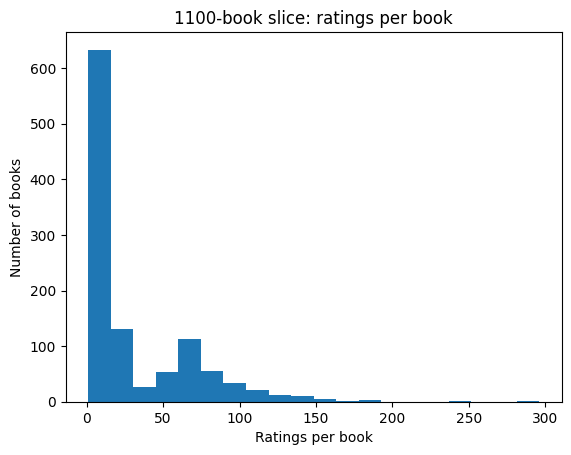

In [15]:
print("\\nCalculating long-tail distribution...")
bc_df = final_slice.groupBy("ISBN").count().orderBy(F.desc("count"))

# Collect the result to the driver as a pandas DataFrame
bc_pandas_df = bc_df.toPandas()

# Now, use the pandas logic for plotting
cum = bc_pandas_df['count'].cumsum() / bc_pandas_df['count'].sum()
n80 = (cum <= 0.8).sum()

#The denominator is the total number of unique books in the slice
total_books = len(bc_pandas_df)
print(f"{n80}/{total_books} books cover 80% → {n80/total_books:.1%}")

# Plotting using matplotlib
plt.hist(bc_pandas_df['count'].values, bins=20)
plt.title(f"{total_books}-book slice: ratings per book")
plt.xlabel("Ratings per book")
plt.ylabel("Number of books")
plt.show()

In [16]:
GITHUB_RAW_BASE = "https://raw.githubusercontent.com/farhodibr/PROJECT5/main"
SINGLE_URL      = f"{GITHUB_RAW_BASE}/book_metadata/metadata_all.csv"
PARTS_URL_FMT   = f"{GITHUB_RAW_BASE}/book_metadata_parts/metadata_part_{{}}.csv"

OUTPUT_DIR      = "book_metadata_parts"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# test if a raw GitHub URL exists 
def remote_exists(url: str) -> bool:
    try:
        return requests.head(url, timeout=5).status_code == 200
    except requests.RequestException:
        return False

final_schema = StructType([
    StructField("ISBN",             StringType(), True),
    StructField("title",            StringType(), True),
    StructField("description",      StringType(), True),
    StructField("authors",          StringType(), True),
    StructField("publish_date",     StringType(), True),
    StructField("publisher",        StringType(), True),
    StructField("number_of_pages",  IntegerType(), True),
    StructField("subjects",         StringType(), True)
])

# Try loading the single combined CSV from GitHub 
if remote_exists(SINGLE_URL):
    print("✅ Found metadata_all.csv on GitHub. Loading via pandas → Spark.")
    pdf = pd.read_csv(SINGLE_URL)
    # ensure integer pages
    pdf['number_of_pages'] = pdf['number_of_pages'].fillna(0).astype(int)
    metadata_df = (
        spark.createDataFrame(pdf, schema=final_schema)
             .cache()
    )

# Else try loading numbered parts from GitHub 
elif remote_exists(PARTS_URL_FMT.format(1)):
    print("found metadata parts on GitHub. Loading all parts via pandas → Spark.")
    parts_urls = []
    i = 1
    while remote_exists(PARTS_URL_FMT.format(i)):
        parts_urls.append(PARTS_URL_FMT.format(i))
        i += 1

    pdfs = []
    for url in parts_urls:
        part = pd.read_csv(url)
        part['number_of_pages'] = part['number_of_pages'].fillna(0).astype(int)
        pdfs.append(part)

    all_pdf = pd.concat(pdfs, ignore_index=True).drop_duplicates("ISBN")
    metadata_df = (
        spark.createDataFrame(all_pdf, schema=final_schema)
             .cache()
    )

#Otherwise fall back to fetching via Google Books API
else:
    print("No GitHub metadata found. Fetching via Google Books API…")
    GOOGLE_API_KEY = ""
    if not GOOGLE_API_KEY:
        raise RuntimeError("Please set the GOOGLE_BOOKS_API_KEY env var.")

    def build_url(isbn: str) -> str:
        return (
            f"https://www.googleapis.com/books/v1/volumes"
            f"?q=isbn:{isbn}&key={GOOGLE_API_KEY}"
        )

    def fetch_single_book_metadata(isbn, max_retries=3, initial_delay=1):
        url   = build_url(isbn)
        delay = initial_delay
        for attempt in range(1, max_retries+1):
            resp = requests.get(url, timeout=15)
            if resp.status_code == 429:
                ra   = resp.headers.get("Retry-After")
                wait = float(ra) if ra else delay
                print(f"[429] {isbn}, retry {attempt}/{max_retries} in {wait}s")
                time.sleep(wait)
                delay *= 2
                continue
            try:
                resp.raise_for_status()
                data = resp.json()
            except Exception as e:
                print(f"[ERROR] {isbn} attempt {attempt}: {e}")
                time.sleep(delay)
                delay *= 2
                continue
            items = data.get("items")
            if not items:
                return {"ISBN": isbn}
            info  = items[0].get("volumeInfo", {})
            pages = info.get("pageCount")
            try:
                pages = int(pages) if pages is not None else 0
            except:
                pages = 0
            time.sleep(0.3)
            return {
                "ISBN":            isbn,
                "title":           info.get("title", ""),
                "description":     info.get("description", ""),
                "authors":         ", ".join(info.get("authors", [])),
                "publish_date":    info.get("publishedDate", ""),
                "publisher":       info.get("publisher", ""),
                "number_of_pages": pages,
                "subjects":        ", ".join(info.get("categories", []))
            }
        print(f"[FAILED] ISBN {isbn} after {max_retries} attempts.")
        return {"ISBN": isbn, "number_of_pages": 0}

    def chunker(seq, size):
        for i in range(0, len(seq), size):
            yield seq[i:i+size]

    isbn_list = [r.ISBN for r in final_slice.select("ISBN").distinct().collect()]
    batches   = list(chunker(isbn_list, 100))

    all_results = []
    for idx, batch in enumerate(batches, 1):
        print(f"Batch {idx}/{len(batches)}: fetching {len(batch)} ISBNs…")
        with ThreadPoolExecutor(max_workers=2) as exe:
            futures = [exe.submit(fetch_single_book_metadata, isbn) for isbn in batch]
            for fut in as_completed(futures):
                all_results.append(fut.result())
        time.sleep(10)

    # save and load via Spark
    local_csv = f"{OUTPUT_DIR}/metadata_all_local.csv"
    pd.DataFrame(all_results).to_csv(local_csv, index=False)
    metadata_df = (
        spark.read
             .schema(final_schema)
             .option("header", True)
             .csv(local_csv)
             .cache()
    )


print("Metadata schema:")
metadata_df.printSchema()

preview_cols = ["ISBN", "title", "authors", "publish_date", "number_of_pages"]

print("Sample metadata (subset of columns):")
print(pdf[preview_cols]
      .head(5)
      .to_string(index=False))

print("\n Description snippet (first 150 chars):")
snippet = pdf[["ISBN", "description"]].copy()
snippet["desc_snippet"] = snippet["description"].str.slice(0, 150)
print(snippet[["ISBN", "desc_snippet"]]
      .head(5)
      .to_string(index=False))


✅ Found metadata_all.csv on GitHub. Loading via pandas → Spark.
Metadata schema:
root
 |-- ISBN: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- number_of_pages: integer (nullable = true)
 |-- subjects: string (nullable = true)

Sample metadata (subset of columns):
      ISBN               title                      authors publish_date  number_of_pages
0842329129         Left Behind Tim LaHaye, Jerry B. Jenkins         1995              484
0140258418           The Beach                 Alex Garland         1997              438
0671649728 Moving Beyond Words               Gloria Steinem         1994              352
0380385880              Shanna        Kathleen E. Woodiwiss   1978-08-01              678
034540288X      The Lost World             Michael Crichton         1995              449

 Descri

In [17]:
import os
import urllib.request
import pandas as pd
from sentence_transformers import SentenceTransformer

# download raw CSV if not present
csv_url = "https://raw.githubusercontent.com/farhodibr/PROJECT5/main/book_metadata/metadata_all.csv"
raw_csv = "metadata_all.csv"
if not os.path.exists(raw_csv):
    print(f"downloading metadata to {raw_csv}...")
    urllib.request.urlretrieve(csv_url, raw_csv)

# load the CSV into a pandas DataFrame
data = pd.read_csv(raw_csv)
# filling missing titles and descriptions to ensure all text is string
data["title"] = data["title"].fillna("No Title")
data["description"] = data["description"].fillna("")
data["text"] = data["title"] + " " + data["description"]
# print size of the DataFrame
print(f"loaded {len(data)} records from {raw_csv}")
# show a preview of the DataFrame in nice format with full 'text' column
pd.set_option("display.max_colwidth", None)  # show full text
print(data[["ISBN", "title", "authors", "text"]].head(5))

# compute embeddings with SBERT
print("generating embeddings...")
model = SentenceTransformer("all-MiniLM-L6-v2")
embeds = model.encode(data["text"].tolist(), show_progress_bar=True)
data["embedding"] = embeds.tolist()

# save to parquet for spark consumption
parquet_path = "metadata_with_embs.parquet"
data.to_parquet(parquet_path, index=False)
print(f"Saved embeddings to {parquet_path}")

# bulding a content-based recommender using LSH for approximate cosine similarity search
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, expr
from pyspark.ml.feature import BucketedRandomProjectionLSH, Normalizer
from pyspark.ml.functions import array_to_vector

# initializing Spark session
spark = (
    SparkSession.builder
    .appName("SparkRecommenderLSH_Cosine")
    .config("spark.driver.memory", "8g")
    .getOrCreate()
)

# reading the parquet file with embeddings
print("reading embeddings from Parquet...")
df = spark.read.parquet(parquet_path)

# show the schema and a few rows
print("DataFrame schema:")  
df.printSchema()
print("Sample data:")
df.select("ISBN", "title", "authors", "text").show(5, truncate=False)
# connvert the 'embedding' column to a vector type

df_emb = (
    df
    .withColumn("features", array_to_vector("embedding"))
    .drop("embedding")
)

normalizer = Normalizer(inputCol="features", outputCol="unitVec", p=2.0)
df_norm = normalizer.transform(df_emb)



loaded 1100 records from metadata_all.csv
         ISBN                title                       authors  \
0  0842329129          Left Behind  Tim LaHaye, Jerry B. Jenkins   
1  0140258418            The Beach                  Alex Garland   
2  0671649728  Moving Beyond Words                Gloria Steinem   
3  0380385880               Shanna         Kathleen E. Woodiwiss   
4  034540288X       The Lost World              Michael Crichton   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Saved embeddings to metadata_with_embs.parquet
reading embeddings from Parquet...
DataFrame schema:
root
 |-- ISBN: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- publish_date: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- number_of_pages: double (nullable = true)
 |-- subjects: string (nullable = true)
 |-- text: string (nullable = true)
 |-- embedding: array (nullable = true)
 |    |-- element: double (containsNull = true)

Sample data:
+----------+-------------------+----------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [18]:
# fitting LSH on unit vectors for approximate cosine search (via Euclidean on unit sphere)
lsh = BucketedRandomProjectionLSH(
    inputCol="unitVec",
    outputCol="hashes",
    bucketLength=1.0,
    numHashTables=5
)
lsh_model = lsh.fit(df_norm)

# function to recommend books based on a given book title
# it finds the k nearest neighbors based on cosine similarity
def recommend(book_title: str, k: int = 5):
    # locate the unit vector for the book
    target_row = df_norm.filter(col("title") == book_title).select("unitVec").first()
    if not target_row:
        print(f"Book '{book_title}' not found.")
        return
    target_vec = target_row[0]

    # find neighbors (Euclidean on unit sphere) and exclude self
    neighbors = lsh_model.approxNearestNeighbors(df_norm, target_vec, k + 1)
    recs = (
        neighbors
        .filter(col("title") != book_title)
        .withColumn("cosine_similarity", expr("1 - (distCol * distCol) / 2"))
        .orderBy(col("cosine_similarity").desc())
        .limit(k)
    )
    print(f"Top {k} recommendations for '{book_title}' (cosine similarity):")
    recs.select("title", "authors", "cosine_similarity").show(truncate=False)

#   recommendations for a few example books
print("\nGenerating recommendations for example books:")
for t in ["The Firm", "Left Behind", "The Pelican Brief"]:
    recommend(t, k=5)   

spark.stop()



Generating recommendations for example books:
Top 5 recommendations for 'The Firm' (cosine similarity):
+-------------------+-------------+-------------------+
|title              |authors      |cosine_similarity  |
+-------------------+-------------+-------------------+
|Personal Injuries  |Scott Turow  |0.6128321928681237 |
|The Devil's Code   |John Sandford|0.5289702813981185 |
|"B" is for Burglar |Sue Grafton  |0.4902906128326556 |
|The Street Lawyer  |John Grisham |0.47581760652245597|
|"H" is for Homicide|Sue Grafton  |0.4302336111086128 |
+-------------------+-------------+-------------------+

Top 5 recommendations for 'Left Behind' (cosine similarity):
+---------------------+----------------------------+------------------+
|title                |authors                     |cosine_similarity |
+---------------------+----------------------------+------------------+
|Tribulation Force    |Tim LaHaye, Jerry B. Jenkins|0.5869429752933417|
|The Last Day         |Glenn Kleier      